# Link Prediction with GCN & GAT in TopoBench

This notebook shows how we extend TopoBench to support link prediction task with standard GNN backbones (GCN, and GAT) for both **transductive** and **inductive** graph datasets.

We will:

- Configure datasets (Cora, MUTAG) for edge-level tasks.
- Use PyTorch Geometric’s `RandomLinkSplit` to build link-prediction splits.
- Integrate dynamic negative sampling into TopoBench’s dataloading.
- Use a custom edge-level readout (`LinkPredictionReadOut`) on top of GCN/GAT.
- Train and evaluate GCN/GAT for a small number of epochs.
- Visualize the positive / negative edges in train/val/test splits.

---

## 1. What We Added to TopoBench

We briefly summarize the changes needed to support link prediction:

- **Edge-level splits**
  - `load_edge_transductive_splits(preprocessor, split_params)`  
    - Wraps PyG’s `RandomLinkSplit` on a single transductive graph (e.g. Cora).  
    - Returns `DataloadDataset` objects for train / val / test.
  - `load_edge_inductive_splits(preprocessor, split_params)`  
    - Reuses TopoBench’s existing graph-level splitting logic (random / k-fold / fixed) for multi-graph datasets.  
    - For each split, attaches edge-level labels and performs one-off negative sampling for val/test.

- **Dynamic vs static negatives**
  - Train split: dynamic negative sampling every epoch via `NegativeSamplingTransform` acting on `edge_label_index`.
  - Val/Test splits: static negatives created once when building the splits
    (via `RandomLinkSplit` in the transductive case, and via our helper in the inductive case).

- **Dynamic negative sampling**
  - `NegativeSamplingTransform` (in `topobench.transforms.data_manipulations`).
  - For each training epoch, it:
    - takes current positive edges via `edge_label_index`
    - samples fresh negative edges using `torch_geometric.utils.negative_sampling`
    - rebuilds `edge_label_index` and `edge_label` with 1/0 labels.

- **Edge-level readout**
  - `LinkPredictionReadOut`:
    - takes node embeddings `x_0` from the backbone
    - scores candidate edges with dot products
    - outputs 2-class logits for *(no edge, edge)*.

- **Config changes**
  - `dataset.parameters.task_level: edge`
  - `dataset.parameters.num_classes: 2` (edge exists / does not exist)
  - `split_params` extended with:
    - `val_prop`, `test_prop`
    - `is_undirected`
    - `neg_pos_ratio`, `neg_sampling_method`, `neg_sampling_ratio`
  - `model.readout.readout_name: LinkPredictionReadOut`
  - We reuse existing backbones (`GCN`, `GAT`) from TopoBench / PyG.

---

## 2. Transductive Link Prediction on Cora

We first look at the **transductive** setting on the Cora citation graph:

- Load Cora with `Planetoid`.
- Apply `RandomLinkSplit` to obtain train / val / test edge splits:
  - `edge_index`: structural graph used for message passing
  - `edge_label_index`, `edge_label`: candidate edges and their labels (1 = positive, 0 = negative).
- Visualize each split (train / val / test) by:
  - building a NetworkX graph
  - coloring positive candidate edges in green, negative candidate edges in red.

In this section we use only `PyTorch Geometric` to explore how `RandomLinkSplit` organizes edges into train/val/test splits and how positive/negative candidate edges look structurally. This gives an intuitive view of what the link-prediction model sees in each phase.

Below we show the complete TopoBench config for the Cora dataset in the transductive link prediction setting, which can be easily adapted to any other transductive dataset.

```yaml
# Dataset loader config (Unchanged)
loader:
  _target_: topobench.data.loaders.PlanetoidDatasetLoader
  parameters: 
    data_domain: graph
    data_type: cocitation
    data_name: Cora
    data_dir: ${paths.data_dir}/${dataset.loader.parameters.data_domain}/${dataset.loader.parameters.data_type}

# Dataset parameters (Changed)
parameters:
  num_features: 1433
  num_classes: 2                # edge exists / does not exist
  num_nodes: 2708
  task: classification
  loss_type: cross_entropy
  monitor_metric: auroc
  task_level: edge

# Splits (Extended)
split_params:
  learning_setting: transductive
  data_split_dir: ${paths.data_dir}/data_splits/${dataset.loader.parameters.data_name}
  data_seed: 0
  split_type: random          # or "k-fold"
  k: 10                       # for k-fold CV
  train_prop: 0.8             # for random splitting
  val_prop: 0.1
  test_prop: 0.1
  is_undirected: True
  neg_sampling_ratio: 1.0     # val/test: #neg ≈ #pos
  neg_pos_ratio: 1.0          # train: #neg ≈ #pos
  neg_sampling_method: sparse
  task_level: edge

# Dataloader parameters (Unchanged)
dataloader_params:
  batch_size: 1               # fixed in transductive case
  num_workers: 1
  pin_memory: False

Key points:

- `task_level: edge`: we’re doing link prediction (edge-level task).
- `num_classes: 2`: binary classification: edge vs no-edge.
- `split_params` control:
  - how we split nodes/edges: `train_prop`, `val_prop`, `test_prop`
  - graph symmetry: `is_undirected`
  - negative sampling in train vs val/test:
    - `neg_pos_ratio`: dynamic negatives per positive edge in training
      (via our `NegativeSamplingTransform`)
    - `neg_sampling_ratio`: static negatives per positive edge in val/test
      (from `RandomLinkSplit`).

In [1]:
# Imports and helpers

import torch
import networkx as nx
import matplotlib.pyplot as plt

from matplotlib.lines import Line2D
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.utils import to_networkx

import os
import sys
from pathlib import Path

import hydra
from hydra.core.global_hydra import GlobalHydra

sys.path.insert(0, str(Path.cwd().parents[0] / "test" / "_utils"))
from simplified_pipeline import run

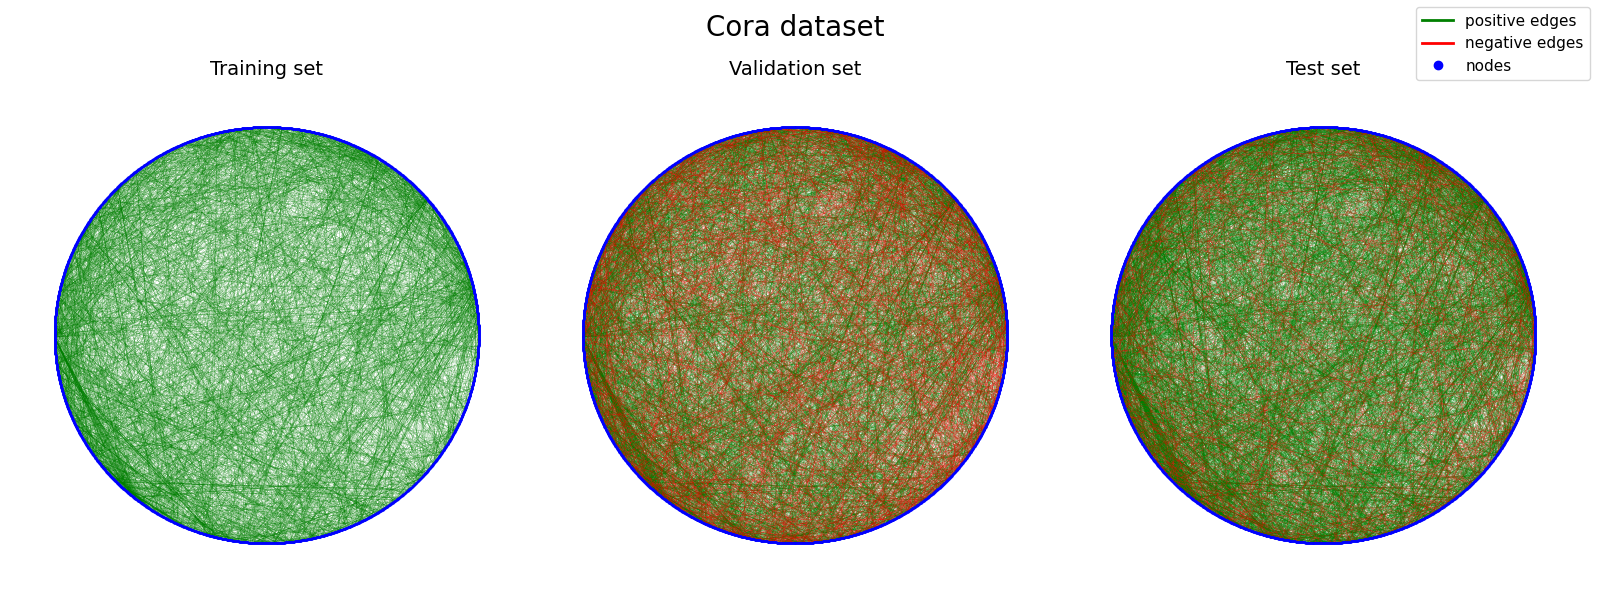

In [6]:
dataset = Planetoid(root=".", name="Cora")
full_data = dataset[0]

splitter = RandomLinkSplit(
    num_val=0.25,
    num_test=0.15,
    is_undirected=True,
    add_negative_train_samples=False,
    neg_sampling_ratio=1.0,
)

train_data, val_data, test_data = splitter(full_data)

titles = ["Training set", "Validation set", "Test set"]
parts = [train_data, val_data, test_data]

graphs = []
layouts = []
pos_edges_list = []
neg_edges_list = []

for title, data_part in zip(titles, parts):
    # Structural graph from edge_index
    G = to_networkx(data_part, to_undirected=True)

    # Candidate edges (positive + negative)
    if not hasattr(data_part, "edge_label_index") or not hasattr(
        data_part, "edge_label"
    ):
        raise RuntimeError(f"{title} must have edge_label_index and edge_label.")

    edge_label_index = data_part.edge_label_index  # [2, E_cand]
    edge_label = data_part.edge_label              # [E_cand]

    pos_mask = edge_label == 1
    neg_mask = edge_label == 0

    pos_edge_index = edge_label_index[:, pos_mask]
    neg_edge_index = edge_label_index[:, neg_mask]

    # Add negative edges explicitly with an attribute
    for u, v in neg_edge_index.t().tolist():
        G.add_edge(u, v, negative=True)

    # Positive candidate edges: mark them as non-negative
    for u, v in pos_edge_index.t().tolist():
        if G.has_edge(u, v):
            G[u][v]["negative"] = False
        else:
            G.add_edge(u, v, negative=False)

    # Layout + edge collections for plotting
    layout = nx.circular_layout(G)
    pos_edges = [(u, v) for u, v, d in G.edges(data=True) if not d.get("negative", False)]
    neg_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get("negative", False)]

    graphs.append(G)
    layouts.append(layout)
    pos_edges_list.append(pos_edges)
    neg_edges_list.append(neg_edges)

fig, axes = plt.subplots(1, 3, figsize=(16, 6))
fig.suptitle(f"{dataset.name} dataset", fontsize=20)

for ax, G, layout, pos_edges, neg_edges, title in zip(
    axes, graphs, layouts, pos_edges_list, neg_edges_list, titles
):
    # Positive candidate edges (green)
    nx.draw_networkx_edges(
        G, layout, edgelist=pos_edges, edge_color="green", width=0.1, ax=ax
    )
    # Negative candidate edges (red)
    nx.draw_networkx_edges(
        G, layout, edgelist=neg_edges, edge_color="red", width=0.1, ax=ax
    )
    # Nodes
    nx.draw_networkx_nodes(
        G, layout, node_color="blue", node_size=0.5, ax=ax
    )

    ax.set_title(title, fontsize=14)
    ax.axis("off")

legend_elements = [
    Line2D([0], [0], color="green", lw=2, label="positive edges"),
    Line2D([0], [0], color="red",   lw=2, label="negative edges"),
    Line2D([0], [0], marker="o", color="blue", markersize=6,
           linestyle="None", label="nodes"),
]

fig.legend(handles=legend_elements, fontsize=11, loc="upper right")
plt.tight_layout()
plt.show()

### Cora Link Prediction with TopoBench (GCN & GAT)

Next, we run link prediction through the TopoBench pipeline:

- Use a Cora config adapted for link prediction (edge-level task, 2 classes, link-pred split parameters).
- Use GCN and GAT model configs with `LinkPredictionReadOut` as the readout.
- Instantiate the full pipeline (`PreProcessor` to split utilities to `TBDataloader` to `TBModel`).
- Train each model for a few epochs and log training loss and validation metrics.

Below we show how to launch these runs directly from this notebook using the same `run` helper used in the tests.

In [8]:
def run_experiment(dataset_cfg: str, model_cfgs: list[str], max_epochs: int = 5):
    GlobalHydra.instance().clear()
    with hydra.initialize(config_path="../configs", job_name="lp_link_pred", version_base=None):
        for MODEL in model_cfgs:
            cfg = hydra.compose(
                config_name="run.yaml",
                overrides=[
                    f"model={MODEL}",
                    f"dataset={dataset_cfg}",
                    f"trainer.max_epochs={max_epochs}",
                    "trainer.min_epochs=1",
                    "trainer.check_val_every_n_epoch=1",
                    "paths=test",
                    "callbacks=model_checkpoint",
                ],
                return_hydra_config=True,
            )
            print(f"\n=== Running model={MODEL} on dataset={dataset_cfg} ===")
            run(cfg)

run_experiment(
    dataset_cfg="graph/cocitation_cora_link_pred",
    model_cfgs=["graph/gcn_link_pred", "graph/gat_link_pred"],
    max_epochs=1,
)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type                  | Params | Mode 
------------------------------------------------------------------
0 | feature_encoder | AllCellFeatureEncoder | 96.1 K | train
1 | backbone        | GNNWrapper            | 8.4 K  | train
2 | readout         | LinkPredictionReadOut | 0      | train
3 | val_acc_best    | MeanMetric            | 0      | train
------------------------------------------------------------------
104 K     Trainable params
0         Non-trainable params
104 K     Total params
0.418     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode



=== Running model=graph/gcn_link_pred on dataset=graph/cocitation_cora_link_pred ===


Training: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


Could not import module loss.loss: No module named 'loss.loss'; 'loss' is not a package
Could not import module loss.base: No module named 'loss.base'; 'loss' is not a package
Could not import module loss.loss: No module named 'loss.loss'; 'loss' is not a package
Could not import module loss.base: No module named 'loss.base'; 'loss' is not a package


Restoring states from the checkpoint path at /Users/davidleko/Desktop/B2/TopoBench/outputs/checkpoints/epoch_000-v24.ckpt
Loaded model weights from the checkpoint at /Users/davidleko/Desktop/B2/TopoBench/outputs/checkpoints/epoch_000-v24.ckpt


Testing: |                                                                         | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/accuracy       │    0.5417457222938538     │
│        test/auroc         │    0.6374622583389282     │
│         test/loss         │    12.169595718383789     │
│      test/precision       │    0.6487935781478882     │
│        test/recall        │    0.5417457222938538     │
└───────────────────────────┴───────────────────────────┘

Could not import module loss.loss: No module named 'loss.loss'; 'loss' is not a package
Could not import module loss.base: No module named 'loss.base'; 'loss' is not a package


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type                  | Params | Mode 
------------------------------------------------------------------
0 | feature_encoder | AllCellFeatureEncoder | 50.2 K | train
1 | backbone        | GNNWrapper            | 2.2 K  | train
2 | readout         | LinkPredictionReadOut | 0      | train
3 | val_acc_best    | MeanMetric            | 0      | train
------------------------------------------------------------------
52.4 K    Trainable params
0         Non-trainable params
52.4 K    Total params
0.210     Total estimated model params size (MB)
21        Modules in train mode
0         Modules in eval mode



=== Running model=graph/gat_link_pred on dataset=graph/cocitation_cora_link_pred ===


Training: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


Could not import module loss.loss: No module named 'loss.loss'; 'loss' is not a package
Could not import module loss.base: No module named 'loss.base'; 'loss' is not a package
Could not import module loss.loss: No module named 'loss.loss'; 'loss' is not a package
Could not import module loss.base: No module named 'loss.base'; 'loss' is not a package


Restoring states from the checkpoint path at /Users/davidleko/Desktop/B2/TopoBench/outputs/checkpoints/epoch_000-v25.ckpt
Loaded model weights from the checkpoint at /Users/davidleko/Desktop/B2/TopoBench/outputs/checkpoints/epoch_000-v25.ckpt


Testing: |                                                                         | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/accuracy       │    0.5360531210899353     │
│        test/auroc         │    0.5922166705131531     │
│         test/loss         │     8.970507621765137     │
│      test/precision       │    0.6678906679153442     │
│        test/recall        │    0.5360531210899353     │
└───────────────────────────┴───────────────────────────┘

Could not import module loss.loss: No module named 'loss.loss'; 'loss' is not a package
Could not import module loss.base: No module named 'loss.base'; 'loss' is not a package


## 3. Inductive Link Prediction on MUTAG

For the **inductive** setting, we switch to a multi-graph dataset: MUTAG from TUDataset.

- Each sample is a small molecular graph (atoms = nodes, bonds = edges).
- We perform graph-level splits (train / val / test) across molecules.
- Within each graph, we turn its edges into positive edge examples, and:
  - in train graphs, we use `NegativeSamplingTransform` to resample fresh negative edges every epoch;
  - in val/test graphs, we generate static negative edges once (using `negative_sampling` inside our inductive split helper).

Below is the TopoBench config for MUTAG in the inductive link prediction setup:

```yaml
# Dataset loader config
loader:
  _target_: topobench.data.loaders.TUDatasetLoader
  parameters: 
    data_domain: graph
    data_type: TUDataset
    data_name: MUTAG
    data_dir: ${paths.data_dir}/${dataset.loader.parameters.data_domain}/${dataset.loader.parameters.data_type}

# Dataset parameters
parameters:
  num_features:
    - 7  # initial node features
    - 4  # initial edge features
  num_classes: 2
  task: classification
  loss_type: cross_entropy
  monitor_metric: auroc
  task_level: edge
  # Lifting parameters
  max_dim_if_lifted: 3  # maximum dimension of the lifted simplicial complex
  preserve_edge_attr_if_lifted: True

# Splits
split_params:
  learning_setting: inductive
  data_split_dir: ${paths.data_dir}/data_splits/${dataset.loader.parameters.data_name}
  data_seed: 0
  split_type: random           # or "k-fold"
  k: 10                        # only used for k-fold
  train_prop: 0.5              # train fraction (rest split into val/test)
  val_prop: 0.1
  test_prop: 0.1
  is_undirected: True
  neg_sampling_ratio: 1.0      # static negs per positive edge (val/test)
  neg_pos_ratio: 1.0           # dynamic negs per positive edge (train)
  neg_sampling_method: sparse
  task_level: edge

# Dataloader parameters
dataloader_params:
  batch_size: 10
  num_workers: 0
  pin_memory: False

Key points:

- `learning_setting: inductive`: splits are done at the graph level (different molecules in train vs val/test).
- `task_level: edge`, `num_classes: 2`: MUTAG is treated as an edge-level binary task (bond exists vs sampled non-bond).
- `parameters.num_features` is a list: `[node_features, edge_features]`, matching TUDataset’s node/edge attributes.
- `neg_pos_ratio` (train) + `neg_sampling_method`: passed to `NegativeSamplingTransform` for dynamic negatives each epoch.
- `neg_sampling_ratio` (val/test): controls static negatives per positive edge in validation and test graphs.

## 5. MUTAG Link Prediction with TopoBench (GCN & GAT)

Finally, we repeat the same idea on an **inductive** benchmark: MUTAG from TUDataset.

Here we:

- Use the MUTAG link-prediction config (edge-level, inductive splits, node + edge features).
- Reuse the same link-prediction pipeline:
  - dynamic negatives in train via `NegativeSamplingTransform`
  - static negatives in val/test (per-graph) from our inductive splitting helper.
- Train two backbones:
  - `graph/gcn_link_pred`
  - `graph/gat_link_pred`
- Run each for a small number of epochs and log:
  - training loss
  - validation AUROC and other metrics.

The only difference compared to Cora is the inductive setting:
we now predict edges on unseen graphs (new molecules) at validation and test time, rather than on the same graph with masked edges.

In [9]:
run_experiment(
    dataset_cfg="graph/MUTAG_link_pred",
    model_cfgs=["graph/gcn_link_pred", "graph/gat_link_pred"],
    max_epochs=5,
)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type                  | Params | Mode 
------------------------------------------------------------------
0 | feature_encoder | AllCellFeatureEncoder | 533    | train
1 | backbone        | GNNWrapper            | 8.4 K  | train
2 | readout         | LinkPredictionReadOut | 0      | train
3 | val_acc_best    | MeanMetric            | 0      | train
------------------------------------------------------------------
9.0 K     Trainable params
0         Non-trainable params
9.0 K     Total params
0.036     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode



=== Running model=graph/gcn_link_pred on dataset=graph/MUTAG_link_pred ===


Training: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
Restoring states from the checkpoint path at /Users/davidleko/Desktop/B2/TopoBench/outputs/checkpoints/epoch_004-v4.ckpt
Loaded model weights from the checkpoint at /Users/davidleko/Desktop/B2/TopoBench/outputs/checkpoints/epoch_004-v4.ckpt


Testing: |                                                                         | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/accuracy       │    0.7164021134376526     │
│        test/auroc         │    0.7360293865203857     │
│         test/loss         │    19.925357818603516     │
│      test/precision       │    0.7950955629348755     │
│        test/recall        │    0.7164021134376526     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type                  | Params | Mode 
------------------------------------------------------------------
0 | feature_encoder | AllCellFeatureEncoder | 277    | train
1 | backbone        | GNNWrapper            | 2.2 K  | train
2 | readout         | LinkPredictionReadOut | 0      | train
3 | val_acc_best    | MeanMetric            | 0      | train
------------------------------------------------------------------
2.5 K     Trainable params
0         Non-trainable params
2.5 K     Total params
0.010     Total estimated model params size (MB)
21        Modules in train mode
0         Modules in eval mode



=== Running model=graph/gat_link_pred on dataset=graph/MUTAG_link_pred ===


Training: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
Restoring states from the checkpoint path at /Users/davidleko/Desktop/B2/TopoBench/outputs/checkpoints/epoch_002-v2.ckpt
Loaded model weights from the checkpoint at /Users/davidleko/Desktop/B2/TopoBench/outputs/checkpoints/epoch_002-v2.ckpt


Testing: |                                                                         | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/accuracy       │    0.6830688118934631     │
│        test/auroc         │     0.680939793586731     │
│         test/loss         │    13.330698013305664     │
│      test/precision       │    0.7218250036239624     │
│        test/recall        │    0.6830687522888184     │
└───────────────────────────┴───────────────────────────┘